In [15]:
%pip uninstall matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [16]:
"Imports"
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
import matplotlib.pyplot as plt


AttributeError: module 'matplotlib' has no attribute 'get_data_path'

Cliping SMAP Tiff to Odisha Boundaries

In [22]:
'''File Declaration'''
#tif_dir = os.path.abspath('./Inputs/AHRC_tiff_files')
tif_dir = os.path.abspath('./Inputs/tiff_sovan')

odisha_shp = os.path.abspath('./Odisha_shp/ODISHA_PRO.shp')
output_dir = os.path.abspath('./Inputs/Odisha_tiff_files')
os.makedirs(output_dir, exist_ok=True)

sample_file = next((f for f in os.listdir(tif_dir) if f.lower().endswith('.tif')), None)
if sample_file is None:
    raise FileNotFoundError(f"No .tif files found in {tif_dir}")
tif_path = os.path.join(tif_dir, sample_file)


In [23]:
tif_path = os.path.abspath('./Inputs/tiff_sovan/smapnew.tif')


In [12]:
import numpy as np
from rasterio.windows import from_bounds

check_file_path = tif_path
with rasterio.open(check_file_path) as src:
    data = src.read(1)

plt.imshow(data, cmap="plasma_r")
plt.colorbar(label="Value")
plt.title("Colored visualization (reversed)")
plt.show()

# --- Raw rectangle cut around Odisha (no shapefile) ---
# Odisha approximate bounds in EPSG:4326: lon [81, 88], lat [17.5, 23]
odisha_lon_min, odisha_lon_max = 77.0, 89.5
odisha_lat_min, odisha_lat_max = 15.5, 27.5

with rasterio.open(tif_path) as src:
    window = from_bounds(
        odisha_lon_min, odisha_lat_min,
        odisha_lon_max, odisha_lat_max,
        transform=src.transform
    )
    data_rect = src.read(1, window=window)

    print(f"Window: {window}")
    print(f"Rectangle shape: {data_rect.shape}")
    print(f"Total pixels: {data_rect.size}")
    print(f"Non-zero pixels: {(data_rect != 0).sum()}")
    print(f"Zero pixels: {(data_rect == 0).sum()}")
    print(f"Min (non-zero): {data_rect[data_rect != 0].min() if (data_rect != 0).any() else 'N/A'}")
    print(f"Max: {data_rect.max()}")
    print(f"Unique values: {np.unique(data_rect)}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    im0 = axes[0].imshow(data_rect, cmap="plasma_r", origin="upper")
    axes[0].set_title("Odisha rectangle - raw values (0 = background)")
    plt.colorbar(im0, ax=axes[0], label="Pixel value")

    masked = np.where(data_rect == 0, np.nan, data_rect)
    im1 = axes[1].imshow(masked, cmap="plasma_r", origin="upper")
    axes[1].set_title("Odisha rectangle - zeros masked out")
    plt.colorbar(im1, ax=axes[1], label="Pixel value")

    plt.tight_layout()
    plt.show()

NameError: name 'plt' is not defined

In [24]:
"Odisha shapefile: load, fix geometry, dissolve to single polygon"
odisha = gpd.read_file(odisha_shp)

if odisha.crs is None:
    # Shapefile PRJ indicates WGS84 / UTM Zone 45N (EPSG:32645)
    odisha = odisha.set_crs("EPSG:32645", allow_override=True)

# Drop empty geometries and fix invalid ones
odisha = odisha[odisha.geometry.notnull()].copy()
odisha["geometry"] = odisha.geometry.buffer(0)

# Single geometry for masking
odisha_single = odisha.dissolve()


In [28]:
"Clip all SMAP rasters to Odisha boundary"
for file in os.listdir(tif_dir):
    if not file.lower().endswith('.tif'):
        continue

    tif_path = os.path.join(tif_dir, file)
    output_path = os.path.join(output_dir, file)

    with rasterio.open(tif_path) as src:
        if src.crs is None:
            raise ValueError(f"Raster CRS missing for {file}. Define CRS before clipping.")

        # Reproject Odisha geometry to match raster CRS
        if odisha_single.crs != src.crs:
            odisha_proj = odisha_single.to_crs(src.crs)
        else:
            odisha_proj = odisha_single

        raster_bbox = box(*src.bounds)
        poly = odisha_proj.geometry.iloc[0]
        if not raster_bbox.intersects(poly):
            print(f"WARNING: no overlap between raster and Odisha for {file}. Check CRS.")
            continue

        shapes = [mapping(poly)]
        out_image, out_transform = mask(
            src,
            shapes,
            crop=True,
            filled=True,
            all_touched=False,
            nodata=src.nodata if src.nodata is not None else 0
        )

        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": src.nodata if src.nodata is not None else 0
        })

        print(f"Processing file: {file}")
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

    print(f"Saved clipped file to: {output_path}")


In [26]:
for file in os.listdir(output_dir):
    file = os.path.join(output_dir,file)
    os.remove(file)

In [26]:
print("CRS:", odisha.crs)
print("Rows:", len(odisha))
print("Geometry type:", odisha.geom_type.unique())
print("Bounds (minx, miny, maxx, maxy):", odisha.total_bounds)
print("Is valid (first 5):", odisha.is_valid.head())


CRS: EPSG:32645
Rows: 1
Geometry type: <StringArray>
['MultiPolygon']
Length: 1, dtype: str
Bounds (minx, miny, maxx, maxy): [ -96020.69427934 1976974.83064978  549953.11223352 2495528.91771367]
Is valid (first 5): 0    True
dtype: bool


Text(0.5, 1.0, 'Odisha shapefile (original CRS)')

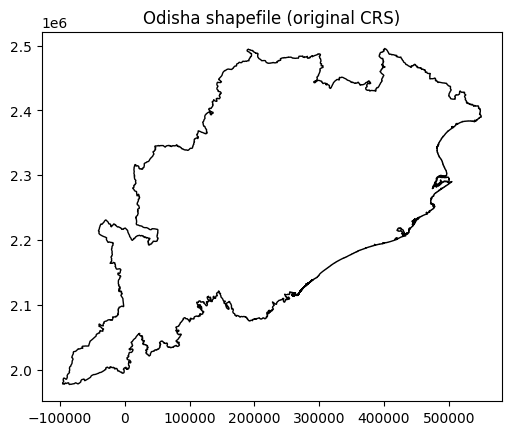

In [8]:
ax = odisha.plot(edgecolor="black", facecolor="none")
ax.set_title("Odisha shapefile (original CRS)")


In [9]:
with rasterio.open(tif_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds

print("Raster CRS:", raster_crs)
print("Raster bounds:", raster_bounds)

odisha_proj = odisha_single.to_crs(raster_crs) if odisha_single.crs != raster_crs else odisha_single
print("Odisha (projected) bounds:", odisha_proj.total_bounds)


Raster CRS: EPSG:4326
Raster bounds: BoundingBox(left=-179.9533233642578, bottom=-46.88755926513673, right=132.3826766357422, top=84.65644073486328)
Odisha (projected) bounds: [81.383003 17.80261  87.482658 22.56359 ]


Text(0.5, 1.0, 'Raster bounds (red) vs Odisha (blue)')

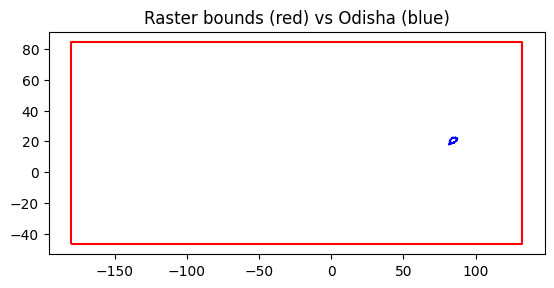

In [30]:
import matplotlib.pyplot as plt
from shapely.geometry import box

with rasterio.open(tif_path) as src:
    raster_bbox = box(*src.bounds)

raster_gdf = gpd.GeoDataFrame(geometry=[raster_bbox], crs=odisha_proj.crs)

ax = raster_gdf.boundary.plot(color="red")
odisha_proj.plot(ax=ax, edgecolor="blue", facecolor="none")
plt.title("Raster bounds (red) vs Odisha (blue)")


In [11]:
from rasterio.features import geometry_mask

with rasterio.open(tif_path) as src:
    odisha_proj = odisha_single.to_crs(src.crs) if odisha_single.crs != src.crs else odisha_single
    poly = odisha_proj.geometry.iloc[0]
    data = src.read(1)
    mask_geom = geometry_mask([mapping(poly)], transform=src.transform, invert=True, out_shape=src.shape)

    nodata = src.nodata
    if nodata is None:
        nodata = 0

    valid = mask_geom & (data != nodata)
    print("Total pixels inside Odisha:", mask_geom.sum())
    print("Valid pixels inside Odisha:", valid.sum())


Total pixels inside Odisha: 2052
Valid pixels inside Odisha: 393
